# Semi-Stochastic Gradient Descent

Author: Sergey Ivanychev

Group: 376

Email: [sergeyivanychev@gmail.com](mailto:sergeyivanychev@gmail.com)

_**Note**: Python 3.5 is used. If your system doesn't provide last language version support, you have to replace `@` operators (matrix product) with equivalent `np.dot()` constructions._

In [82]:
import numpy as np
import operator
from scipy.optimize import approx_fprime
from math import sqrt
import scipy.optimize as opt
from matplotlib import pyplot as plt
from functools import partial
%matplotlib inline

We will call _accumulated function_:

$$
f(x) = \frac{1}{n}\sum_{i=1}^n f_i(x)
$$

[Paper PDF](http://arxiv.org/pdf/1312.1666)

## Implementation

In [97]:
def _gradient(x, f, eps=sqrt(np.finfo(float).eps)):
    """
    Numerical gradient calculation function
    
    x:    argument of f
    f:    calculated function
    eps:  precision
    
    return: np.array(x.shape[0]) with calculated gradient
    """
    return approx_fprime(x, f, eps)

def _f_list_gradient(f_list, x):
    """
    Calculates gradient of accumulated function
    
    f_list:     list of callables
    x:          argument of the function
    
    return:     np.array(x.shape[0]) with calculated gradient
    """
    grads = map(lambda f: _gradient(x, f), f_list)
    return sum(grads) / len(f_list)

def _f_eval(f_list, x):
    """
    Evaluates accumulated function
    f_list:     list of callables
    x:          argument of the function
    
    return:     floating point value of f(x)
    """
    vals = map(lambda f: f(x), f_list)
    return sum(vals) / len(f_list)

def _get_probs(max_steps, step_size, mu_lower):
    """
    Gets array of probabilities related to values [1 .. m] (see S2GD algorithm description)
    
    max_steps, step_size, mu_lower:      see S2GD description
    
    return:     np.array of probabilities
    """
    unnormalized = (1 - mu_lower * step_size) ** (max_steps - np.arange(1, max_steps + 1))
    return unnormalized / np.sum(unnormalized)

In [69]:
def S2GD(f_list, x_0, epoch_num, max_steps, step_size, mu_lower = 0):
    """
    Semi-Stochastic Gradient Method for minimizing accumulated functions
    f_list:            list of f_i according to the defenition of f(x) (see above)
    x_0:               starting point
    epoch_num:         number of outer iterations number
    max_steps:         upper limit of inner iterations number
    step_size:         inner step factor
    mu_lower:          lower bound of strong convexity constant of f(x)
    
    return:            (argmin, min)
    
    Authors:           Jakub Konecny and Peter Richtarik 
    Implemented by:    Sergey Ivanychev
    Link:              http://arxiv.org/abs/1312.1666
    """
    x = x_0
    probs =  _get_probs(max_steps, step_size, mu_lower)
    steps_range = np.arange(1, max_steps + 1)
    nfuncs = len(f_list)
    
    for i in range(epoch_num):
        g = _f_list_gradient(f_list, x)
        y = x
        t_current = np.random.choice(steps_range, p = probs)
        for t in range(t_current):
            j = np.random.randint(0, nfuncs)
            y = y - step_size*(g + _gradient(y, f_list[j]) - _gradient(x, f_list[j]))
        x = y
    return x, _f_eval(f_list, x)

METHODS = {
    "S2GD":S2GD
}

def minimize(method="S2GD", *args, **kwargs):
    return METHODS[method](*args, **kwargs)

## Testing

In [73]:
def _generate_test_f(lambda_, ndim):
    """
    Generating testing log-loss functions
    
    lambda_:      regularizer factor
    ndim:         returning function will be defined in R^ndim
    
    return:       callable f(x)
    """
    a = np.random.rand(ndim)
    y = np.random.randint(0, 2)
    def f(x):
        return lambda_ / 2 * np.linalg.norm(x) - \
               (y * np.log(1 / (1 + np.exp(-x @ a))) + (1 - y) * np.log(1 - 1 / (1 + np.exp(-x @ a))))
    return f

def _get_accumulated_f(f_list):
    num = len(f_list)
    def f(x):
        return 1 / num * sum(map(lambda f: f(x), f_list))
    return f

Here simple accumulated function is generated. We use standard `scipy.optimize.minimize()` function to compare with. The plot below shows how the minimum value converges to the true value with the number of steps increasing.

In [ ]:
funcs = [_generate_test_f(0.1, 3) for i in range(3)]
accumulated_func = _get_accumulated_f(funcs)

x_0 = np.array([0.1, 0.1, 0.1])
arg, val = minimize(method="S2GD", f_list=funcs, x_0 = x_0, epoch_num = 20, max_steps=10, step_size=0.4)

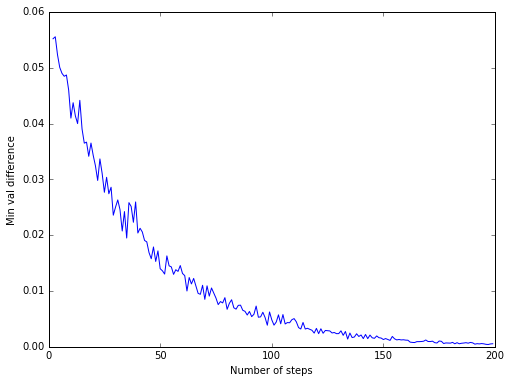

In [99]:
plt.figure(figsize=(8, 6), dpi=130)
nsteps = np.arange(2, 200)
minimize_step = partial(minimize, method="S2GD", f_list=funcs, x_0 = x_0, max_steps=10, step_size=0.4)
results = np.array(list(map(lambda x: minimize_step(epoch_num=x)[1], nsteps)))
trusted = opt.minimize(accumulated_func, x_0)
plt.plot(nsteps, results - trusted.fun)
plt.xlabel("Number of steps")
plt.ylabel("Min val difference")